# Przeuczenie się (ang. [Overfitting](https://bit.ly/3rH7Pvj))

### Celem jest poznanie jednej z największych bolączek w uczeniu maszynowym.

Im szybciej dowiesz się, czym jest przeuczenie się i jak efektywnie tym zarządzać, tym szybciej nauczysz się trenować modele, które mają sens w praktyce ;). Zacznijmy jak zwykle od wczytania bibliotek.

In [2]:
import helper as h
import pandas as pd

import numpy as np
np.random.seed(0) #ustawienia ziarna dla powtarzalności wyników

from IPython.display import display
import ipywidgets as widgets

import xgboost as xgb # w tym module jako ciekawostka, więcej będzie w kolejnym
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.utils import resample
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import scikitplot as skplt #przydatna biblioteka do wizualizacji

import brewer2mpl #mapa kolorów
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

AttributeError: module 'pandas' has no attribute 'tslib'

Zróbmy prosty eksperyment, żeby lepiej zrozumieć, dlaczego występuje overfitting i dlaczego mamy dobre wyniki na zbiorze treningowym, a słabe na zbiorze testowym (lub nowych danych). Zróbmy wizualizację.

Na wykresie:
1. <span style="color:green">**Zielona linia**</span> - to źródło prawdy ("prawo natury" i to czego nie wiemy).
2. <span style="color:red">**Czerwone kropki**</span> - to są dane treningowe (jak widać na dodatek są trochę zaszumione - zdarza się dość często w życiu).
3. <span style="color:green">**Zielone kropki**</span> - to są nowe dane, na których chcemy robić predykcję.

Linia przerywana pokazuje to, jak model "widzi" rzeczywistość.

**Uwaga!** Spróbuj przesuwać suwaczek. Czym większa złożoność modelu (*degree*), tym większe szczegóły model próbuje wychwycić. To jest przyczyną tak zwanego przeuczania się (ang. *overfitting*).

In [2]:
degree = widgets.IntSlider(min=1, max=21, value=2)

w = widgets.interactive(h.plot_overfitting,degree=degree)
display(w)

interactive(children=(IntSlider(value=2, description='degree', max=21, min=1), Output()), _dom_classes=('widge…

W praktyce ciężko jest przetestować model w tak łatwy sposób jak na wykresie powyżej, więc warto mieć jakieś narzędzia, które zapobiegają przeuczeniu się. Proces, który zapobiega przeuczeniu się nazywamy walidacją.

Są różne rodzaje walidacji, ale poznamy najbardziej popularne.

## Walidacja (eng. *validation*)

### Hold out Validation

Najprostszą strategią, którą już wcześniej zastosowaliśmy, jest podzielenie naszego zbioru danych na dwa podzbiory - treningowy i testowy. Zwykle zbiór treningowy będzie większy (ok. 70-80%), ponieważ im więcej danych, tym lepszy model wytrenujemy.

In [3]:
nrows = 10

X = np.random.randint(0, 20, (nrows, 5))
y = np.arange(nrows)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print('y_train index', list(y_train))
print('y_test index', list(y_test))

y_train index [3, 0, 7, 1, 8, 4, 5]
y_test index [9, 2, 6]


Indeksy traktuj jako nr. wiersza, który będzie przypisany do zbioru treningowego oraz testowego.

Na przykład:
```
y_train index [9, 1, 6, 7, 3, 0, 5]
y_test index [2, 8, 4]
```
To oznacza, że wiersze 2,8 oraz 4 trafią do zbioru testowego (czyli model będzie ich używał wyłącznie do testowania), a wszystkie inne elementy trafią do zbioru treningowego.

Ważna rzecz jest taka, że  jeśli uruchomisz tę komórkę więcej niż raz, to zobaczysz różne wyniki. Koniecznie spróbuj!

Dlaczego tak się dzieje?
Dlatego, że nie ustawiliśmy ziarna. Teraz jest moment, aby je ustawić. Warto to robić, bo dzięki temu będziesz miał powtarzalne wyniki. To jest ważne. Czym dalej, tym bardziej to będziesz doceniać. Jak można ustawić ziarenko? Wystarczy dodać `.train_test_split(random_state=0)`. Zwróć uwagę, że teraz wartość jest ustawiona na 0, ale może być inna wartość np. 1 czy 152 (w tym sensie, nie ma "dobrego" ziarna, ale dla każdego będzie inny zamrożony wynik losowości). Sprawdźmy (uruchom kod kilka razy). 

In [4]:
nrows = 10

X = np.random.randint(0, 20, (nrows, 5))
y = np.arange(nrows)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('y_train index', list(y_train))
print('y_test index', list(y_test))

y_train index [9, 1, 6, 7, 3, 0, 5]
y_test index [2, 8, 4]


Jak widzisz, już wynik jest zamrożony, czyli za każdym razem widzimy te same indeksy (nr. wierszy).

Teraz czas poznać kolejny sposób walidacji.

### Bootstrapping
Wyobraź sobie, że masz worek, w którym są podpisane piłeczki. Twoim zadaniem jest wyciągnąć piłeczkę, zapisać jej numer i wrzucić ją z powrotem do worka. W ten sposób istnieje szansa, że wyciągniesz tę samą piłeczkę więcej niż raz. Z drugiej strony istnieją również takie piłeczki, których nigdy nie wyciągniesz. Dokładnie to będziemy robić używając `bootstrapping`. Swoją drogą, jako metoda do walidacji jest używana nie tak często, ale i tak warto ją poznać z uwagi na algorytmy z rodziny bagging (czyli *bootstrap aggregation*). Poznasz te algorytmy w kolejnym module.

Sprawdźmy teraz kod.

In [5]:
np.random.seed(0)
X = np.random.randint(0, 10, (5, 3))

print("Original data:")
print(X)

print('\nBoostraping:')
for i in range(5):
    print("\niteration: {0}".format(i))
    print(resample(X, replace=True, n_samples=3, random_state=i))

Original data:
[[5 0 3]
 [3 7 9]
 [3 5 2]
 [4 7 6]
 [8 8 1]]

Boostraping:

iteration: 0
[[8 8 1]
 [5 0 3]
 [4 7 6]]

iteration: 1
[[4 7 6]
 [8 8 1]
 [5 0 3]]

iteration: 2
[[5 0 3]
 [5 0 3]
 [4 7 6]]

iteration: 3
[[3 5 2]
 [5 0 3]
 [3 7 9]]

iteration: 4
[[3 5 2]
 [3 7 9]
 [5 0 3]]


Załóżmy, że to jest oryginalny zbiór danych (czyli nasz `X`)

```
[[5 0 3]
 [3 7 9]
 [3 5 2]
 [4 7 6]
 [8 8 1]]

```
Mamy 5 iteracji i za każdym razem wyciągamy dane wiersze. Zwróć uwagę, że np. w drugiej iteracji są widoczne powtórzenia, czyli:
```
[[5 0 3]
 [5 0 3]
 [4 7 6]]
```
Pierwsze dwa wiersze są identyczne. Oczywiście w tym przykładzie bardzo łatwo było zrobić powtórzenia. W sumie też o to chodziło, aby pokazać Ci to na przykładzie.


Teraz przechodzimy do kolejnego sposobu walidacji. Jednym z najbardziej popularnych sposobów walidacji jest  tak zwana walidacja krzyżowa (lub po angielsku `cross-validation`).

### Cross-Validation: k-fold

Czasem jest też nazywana `k-fold` walidacja. Polega ona na tym, że dzielimy nasz zbiór na `k` podzbiorów, następnie jeden z nich wydzielamy, pozostałe natomiast służą do trenowania modelu. Po wytrenowaniu modelu walidujemy, jak poradził sobie na wydzielonym wcześniej podzbiorze. Następnie bierzemy drugi podzbiór i powtarzamy cały proces. Robimy tak `k` razy, a na samym końcu bierzemy średni wynik ze wszystkich podzbiorów.

Zobacz na poniższym przykładzie, jak działa `k-fold` walidacja. Prześledź, w jaki sposób są dzielone dane (patrz na kolor i liczby kwadracików).

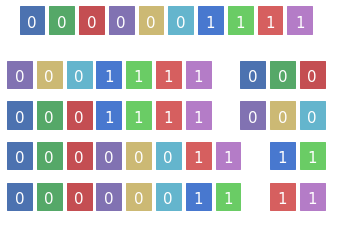

In [8]:
import helper as h

labels = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1] 
#labels = ['a', 'a', 'b', 'a', 'a', 'a', 'a', 'b', 'b', 'a']  możesz spróbować literki, może to będzie bardziej wizualnie dla Ciebie

skf = KFold(n_splits=4) #sprawdź dla 2 czy 3

h.plot_kfold(skf, labels)

Czy widzisz, jaki problem pojawił się dla 4 foldów? Mamy sytuację, kiedy dwa razy w odpowiedziach znajdują się tylko zera lub tylko jedynki.

Jeszcze raz o **k-fold**, tylko z innej strony, gdzie mamy **450 wierszy** i **10 foldów** (czyli k=10).

![](../images/kfold.gif)

### Stratified k-fold
Zapewnia, że odpowiedzi na każdej iteracji będą posiadać mniej więcej ten sam rozkład.

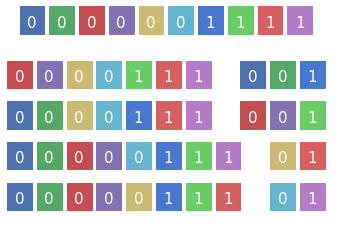

In [9]:
labels = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1] 
skf = StratifiedKFold(n_splits=4) #check for 2 or 3

h.plot_kfold(skf, labels)

## Cross-Validation
Przykład użycia w życiu [KFold](https://bit.ly/2PNOaga) ([StratifiedKFold](https://bit.ly/2Oevw0m) będzie identyczny).

Na początek potrzebujemy mieć **X** i **y**.

In [10]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])

Następnie mówimy, ile chcemy mieć **fold**ów. 

**Uwaga!** W nowszej wersji *sklearn* zamiast **foldów** używa się terminu **split** (ale sens jest ten sam).

**Polecam**:
- Ustawiać `random_state` dla powtarzalności wyniku.
- Ustawiać `Shuffle` na `True` tym samym upewniając się, że te dane będą "bardziej" losowe.

In [11]:
cv = KFold(n_splits=2, random_state=2019, shuffle=True)

Następnie `cv` zapewnia nam indeksy, które wykorzystujemy, żeby odwołać się do naszej macierzy **X** i wektora **y**.

In [12]:
for train_idx, test_idx in cv.split(y):
    #X[train_idx], y[train_idx]
    #X[test_idx]
    print("TRAIN:", train_idx, "TEST:", test_idx)

TRAIN: [0 2] TEST: [1 3]
TRAIN: [1 3] TEST: [0 2]


Dodajmy model i zbierzmy to w całość.

In [13]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])

cv = KFold(n_splits=2, random_state=2018, shuffle=True)
model = DummyRegressor()

scores = []
for train_idx, test_idx in cv.split(y):
    model.fit(X[train_idx], y[train_idx])
    y_pred = model.predict(X[test_idx])

    score = mean_absolute_error(y[test_idx], y_pred )
    scores.append(score)

print(np.mean(scores), np.std(scores))

2.0 0.0


## Decision Tree & Random Forest

Popatrzmy dokładniej, jak używać drzewa decyzyjnego i lasów losowych (na początek na prostych przykładach).

Zacznę od czegoś ogólnego. Biblioteka `sklearn` jest jedną z najbardziej eleganckich, jaką kiedykolwiek widziałem na oczy (a widziałem różne, w wielu technologiach). W skrócie API wygląda tak:

```
model = ModelRegressor() albo ModelClassifier() #gdzie zamiast Model będzie nazwa algorytmu
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
```

Konkretny przykład:
### DecisionTreeClassifier

```
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
```

### RandomForestClassifier
Jak będzie wyglądał kod dla `RandomForestClassifier()`? Prawie identycznie:

```
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
```

Dlatego zwykle tworzy się funkcję, np. `model_train_predict`, która ułatwia trenowanie i predykcję oraz umożliwia łatwe podmienienie modelu. 

```
def model_train_predict(model, X_train, y_train, X_test, y_test, success_metric=accuracy_score):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return success_metric(y_test, y_pred)
    
    
models = [
    #... inne modele
    DecisionTreeClassifier(),
    RandomForestClassifier()
]

scores = []
for model in models:
    score = model_train_predict(model, X_train, y_train, X_test, y_test)
    scores.append((score, model))
    
```

Wygląda bardzo prosto. Teraz proponuję jeszcze zobaczyć, jak importować, jakie są parametry i już można zacząć używać.

### DecisionTreeClassifier

In [14]:
DecisionTreeClassifier()

DecisionTreeClassifier()

### RandomForestClassifier

In [15]:
RandomForestClassifier()

RandomForestClassifier()

Dodatkowo polecam przetestować `ExtraTreesClassifier`. Działa [podobnie](https://bit.ly/3cHYMWB) jak `RandomForest` tylko jest jeszcze bardziej losowe.

### ExtraTreesClassifier

In [16]:
ExtraTreesClassifier()

ExtraTreesClassifier()

### Najważniejsze parametry:

* `max_depth` => maksymalna głębokość drzew
* `n_estimators` => liczba drzew
* `max_features` => ile cech będzie brane pod uwagę

Reszta zwykle jest już mniej ważna...

## Forest Cover Type Prediction


Już warto przejść do zadania praktycznego, aby zrobić coś ciekawego i utrwalić wiedzę na temat walidacji. W szczególności teraz będziemy używać walidacji krzyżowej.

Zadaniem jest wykonać predykcję rodzaju lesistości (dominujący rodzaj lesistości) od ścisłych 
kartograficznych zmiennych (w przeciwieństwie do teledetekcji). Aktualny rodzaj lesistości dla danej komórki 30x30 metrów został ustalony z US Forest Service (USFS).

![](../images/forecast.png)
 
 
W tym zadaniu trzeba wykonać prognozę rodzaju pokrywy leśnej (dominujący rodzaj pokrywy drzewnej) na podstawie zmiennych ściśle kartograficznych. Rzeczywisty typ pokrycia lasu dla danej komórki 30 x 30 metrów określono z US Forest Service.


Link do [Kaggle](https://www.kaggle.com/c/forest-cover-type-prediction) (gdzie można poczytać więcej).

Najpierw wczytajmy dane.

In [17]:
train = pd.read_hdf('forest_type.h5')
train.shape

(15120, 56)

Kilka ciekawostek... Na początku dane z kaggle były w formacie .csv i po wczytaniu zajmowały ponad 6 razy więcej (akurat w tym przypadku, jeśli chodzi o ilość, to nadal jest raczej mało, ale redukcja rozmiaru ponad 6 razy to jest super wynik). 

Poniżej jest kod do tego, jak to zrobiłem. Również masz dostęp do csv, jeśli chcesz możesz sprawdzić :)

```
train = pd.read_csv('../input/forest_cover_type_train.csv')

for column in train.columns:
    print( column, train[column].max() )
    
#i następnie było widać do jakiego typu redukować

for column in train.columns:
    if 'Soil' in column or 'Wilderness' in column: 
        train[ column ] = train[ column ].astype('int8')

train[ 'Slope' ] = train[ 'Slope' ].astype('int8')
train[ 'Cover_Type' ] = train[ 'Cover_Type' ].astype('int8')

cols_int16 = ['Id', 'Elevation', 'Aspect', 'Horizontal_Distance_To_Hydrology', \
              'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', \
              'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
             ]

for col in cols_int16:
    train[ col ] = train[ col ].astype('int16')
    
#train.to_hdf('../input/forest_type.h5', 'data')  #uważaj, możesz nadpisać swoje dane!!!
```


Jak już wiesz, to wczytujemy dane i patrzymy na nie, najpierw przy pomocy funkcji `.info()`, a później na inne sposoby, np.  `.head()` lub zaczynamy wizualizować.

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int16
 1   Elevation                           15120 non-null  int16
 2   Aspect                              15120 non-null  int16
 3   Slope                               15120 non-null  int8 
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int16
 5   Vertical_Distance_To_Hydrology      15120 non-null  int16
 6   Horizontal_Distance_To_Roadways     15120 non-null  int16
 7   Hillshade_9am                       15120 non-null  int16
 8   Hillshade_Noon                      15120 non-null  int16
 9   Hillshade_3pm                       15120 non-null  int16
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int16
 11  Wilderness_Area1                    15120 non-null  int8 
 12  Wild

In [19]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


**Elevation** - Elevation in meters  
**Aspect** - Aspect in degrees azimuth  
**Slope** - Slope in degrees  
**Horizontal_Distance_To_Hydrology** - Horz Dist to nearest surface water features    
**Vertical_Distance_To_Hydrology** - Vert Dist to nearest surface water features  
**Horizontal_Distance_To_Roadways** - Horz Dist to nearest roadway  
**Hillshade_9am** (0 to 255 index) - Hillshade index at 9am, summer solstice  
**Hillshade_Noon** (0 to 255 index) - Hillshade index at noon, summer solstice   
**Hillshade_3pm** (0 to 255 index) - Hillshade index at 3pm, summer solstice  
**Horizontal_Distance_To_Fire_Points** - Horz Dist to nearest wildfire ignition points  
**Wilderness_Area** (4 binary columns, 0 = absence or 1 = presence) - Wilderness area   designation  
**Soil_Type** (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation  
**Cover_Type** (7 types, integers 1 to 7) - Forest Cover Type designation  

The wilderness areas are:

1. Rawah Wilderness Area  
2. Neota Wilderness Area
3. Comanche Peak Wilderness Area
4. Cache la Poudre Wilderness Area

The soil types are:

1. Cathedral family - Rock outcrop complex, extremely stony.
2. Vanet - Ratake families complex, very stony.
3. Haploborolis - Rock outcrop complex, rubbly.
4. Ratake family - Rock outcrop complex, rubbly.
5. Vanet family - Rock outcrop complex complex, rubbly.
6. Vanet - Wetmore families - Rock outcrop complex, stony.
7. Gothic family.
8. Supervisor - Limber families complex.
9. Troutville family, very stony.
10. Bullwark - Catamount families - Rock outcrop complex, rubbly.
11. Bullwark - Catamount families - Rock land complex, rubbly.
12. Legault family - Rock land complex, stony.
13. Catamount family - Rock land - Bullwark family complex, rubbly.
14. Pachic Argiborolis - Aquolis complex.
15. unspecified in the USFS Soil and ELU Survey.
16. Cryaquolis - Cryoborolis complex.
17. Gateview family - Cryaquolis complex.
18. Rogert family, very stony.
19. Typic Cryaquolis - Borohemists complex.
20. Typic Cryaquepts - Typic Cryaquolls complex.
21. Typic Cryaquolls - Leighcan family, till substratum complex.
22. Leighcan family, till substratum, extremely bouldery.
23. Leighcan family, till substratum - Typic Cryaquolls complex.
24. Leighcan family, extremely stony.
25. Leighcan family, warm, extremely stony.
26. Granile - Catamount families complex, very stony.
27. Leighcan family, warm - Rock outcrop complex, extremely stony.
28. Leighcan family - Rock outcrop complex, extremely stony.
29. Como - Legault families complex, extremely stony.
30. Como family - Rock land - Legault family complex, extremely stony.
31. Leighcan - Catamount families complex, extremely stony.
32. Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
33. Leighcan - Catamount families - Rock outcrop complex, extremely stony.
34. Cryorthents - Rock land complex, extremely stony.
35. Cryumbrepts - Rock outcrop - Cryaquepts complex.
36. Bross family - Rock land - Cryumbrepts complex, extremely stony.
37. Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
38. Leighcan - Moran families - Cryaquolls complex, extremely stony.
39. Moran family - Cryorthents - Leighcan family complex, extremely stony.
40. Moran family - Cryorthents - Rock land complex, extremely stony.

Zobaczmy, jakie mamy kolumny.

In [20]:
train.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

## Zmienna docelowa

Zbadajmy lepiej naszą zmienną docelową, aby lepiej uświadomić, co model ma zwracać.

In [21]:
train['Cover_Type'].unique()

array([5, 2, 1, 7, 3, 6, 4], dtype=int8)

Mamy 7 unikalnych klas, czyli mamy do czynienia z tak zwaną [Multi-label classification](https://bit.ly/2PO0FrV). To jest trochę trudniejszy przypadek niż klasyfikacja binarna. Spokojnie, nie ma co się bać, ale kilka rzeczy będzie pod górkę.

## Zadanie 2.4.2
1. Zbuduj `DummyRegressor` model i potem wersję liniową (`LogisticRegression`)
2. Zastosuj k-fold walidację, np. k=3

In [27]:
columns = list(train.columns)
features = columns[0:len(columns)-1]
target = columns[-1]

X = train[features].values
y = train[target].values

cv = KFold(n_splits=3, random_state=2018, shuffle=True)
model = DummyClassifier()

def useModel(model):
    scores = []
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        score = mean_absolute_error(y[test_idx], y_pred )
        scores.append(score)


    print(np.mean(scores), np.std(scores))
    print(cross_val_score(DummyClassifier(), X, y, cv=3, scoring='accuracy'))

## Zadanie 2.4.3
1. Użyj bardziej zaawansowanych modeli: **DecisionTree**, **RandomForest**, **ExtraTree**.
2. Zacznij pracować nad nowymi cechami.
3. Sprawdź ważność cech.

In [32]:
[useModel(model) for model in [DecisionTreeClassifier(), RandomForestClassifier(), ExtraTreesClassifier()]]



0.5494708994708994 0.0024372388588212355
[0.13869048 0.14107143 0.14444444]
0.333531746031746 0.01867399772357529
[0.14027778 0.13611111 0.13948413]
0.3443783068783069 0.006991213135966523
[0.14325397 0.14206349 0.1390873 ]


[None, None, None]

Pomogę Ci trochę i też podpowiem, gdzie można przyspieszyć. Tylko najpierw trzeba upewnić się, czy mamy przygotowany `X` oraz `y`. W tym celu zróbmy dwie funkcje:
- `get_feats()` - zwraca numeryczne cechy z DataFrame za wyjątkiem tych, które są na czarnej liście (np. zmienna docelowa)
- `get_X_y()` - zwraca naszego `X` oraz `y`

In [33]:
def get_feats(df, black_list=['Cover_Type', 'Id']):
    num_feats = df.select_dtypes(np.number).columns
    return [x for x in num_feats if x not in black_list]

def get_X_y(df, feats=None):
    if feats is None:
        feats = get_feats(df)
        
    X = train[feats].values
    y = train['Cover_Type'].values
    
    return X, y


X, y = get_X_y(train)

Poprzednio pokazałem, jak zbudować walidację krzyżową używać `KFold` wprost i pisząc pętle. To warto wiedzieć, bo czasem faktycznie trzeba tak robić, ale jeśli mamy w miarę standardowy przypadek do sprawdzenie, to szybciej będzie użyć funkcji `.cross_val_score()`

Sprawdźmy na dummy model.

### Dummy

In [34]:
cross_val_score(DummyClassifier(), X, y, cv=3, scoring='accuracy')

array([0.13769841, 0.14186508, 0.14543651])

Widać, że w tym przypadku dummy model ma bardzo kiepski wyniki ok. 13-14% Sprawdźmy teraz wynik na modelu liniowym.

### Liniowy model

In [35]:
cross_val_score(LogisticRegression(solver='lbfgs', multi_class='multinomial'), X, y, cv=3, scoring='accuracy')

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

array([0.47619048, 0.39623016, 0.45496032])

Mamy wynik już znacznie lepszy niż przy dummy. już ok. 40-47%. Dodatkowo jak zwiększymy parametr `max_iter` np. na 500, to możemy "wycisnąć" jeszcze trochę więcej, ale to też będzie wolniej się liczyć. Sprawdźmy.


In [36]:
cross_val_score(LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500), X, y, cv=3, scoring='accuracy')

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

array([0.50535714, 0.49742063, 0.55238095])

Jak widać wynik poprawił się, teraz mamy ok. 50-55%. Można próbować jeszcze zwiększyć `max_iter`, ale to już może powodować różne trudności (np. przeuczenie się), więc chodźmy dalej. Sprawdźmy model drzewo decyzyjne.

## Decision Tree

In [37]:
cross_val_score(DecisionTreeClassifier(max_depth=5), X, y, cv=3, scoring='accuracy')

array([0.58492063, 0.59980159, 0.66646825])

Wynik znacząco jest lepszy, już mamy ok. 58-66%.

Sprawdźmy trochę dokładniej, gdzie mylimy się, czyli zobaczmy `confusion-matrix`. W tym przypadku będzie macierz 7x7 (bo tyle mamy unikalnych wartości [klas] w zmiennej docelowej).

Aby ułatwić trochę nam życie, użyjemy dwóch funkcji:
- `.cross_val_predict()`, która zrobi walidację krzyżową i zwróci nam wynik (czyli `y_pred`)
-  `skplt.metrics.plot_confusion_matrix()`, do zrobienia `confusion matrix` w prosty sposób.

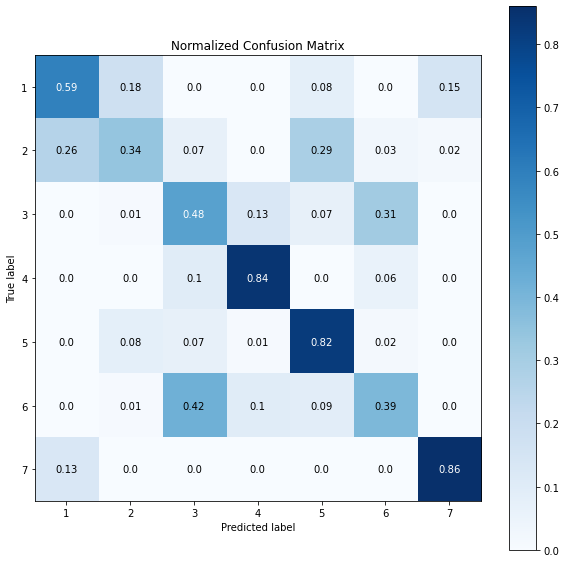

In [38]:
y_pred = cross_val_predict(DecisionTreeClassifier(max_depth=5), X, y, cv=3)
skplt.metrics.plot_confusion_matrix(y, y_pred, normalize=True, figsize=(10 ,10));

Jak to interpretować?
W idealnym przypadku na przekątnej powinno być 1.0, a w innych miejscach same zera. 

Zobacz, teraz mocno mylimy klasę 6 z klasą 3 (czyli w 42% przypisaliśmy jako klasa 3, natomiast była 6). 


### Ważność cech
Aby ułatwić życie i przyspieszyć proces, użyjemy do tego `skplt.estimators.plot_feature_importances()`.

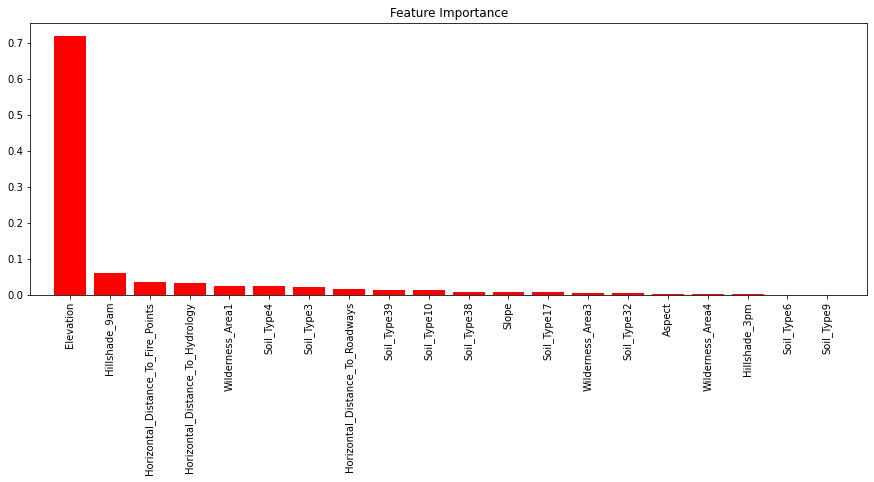

In [39]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X, y)

feats = get_feats(train)
skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5));

### Krzywa uczenia się
Zróbmy jeszcze krzywą uczenia się, aby mieć kontrolę nad tym, czy model nie przeucza się.

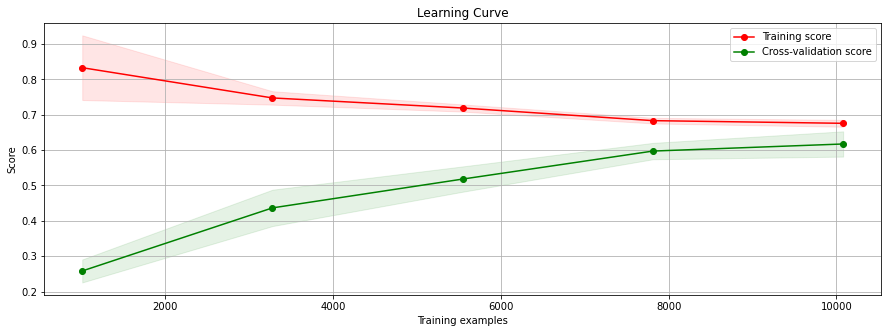

In [40]:
skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='accuracy');

## Radom Forest

Teraz sprawdźmy, jak radzi sobie algorytm lasy losowe. Jak ten algorytm działa pod spodem będzie więcej w kolejnym module, ale na razie po prostu go uruchomimy ;).

Zakładam, że już masz funkcję `run_cv_model()`. Jeśli jednak nie, to masz ją poniżej. Dodałem też tam kilka parametrów domyślnych.

In [41]:
def run_cv_model(model_cls, model_params, X, y, feats, cv=3, scoring='accuracy', plot_learning_curve=True, plot_confusion_matrix=True, plot_feature_importances=True):

    scores = cross_val_score(model_cls(**model_params), X, y, cv=cv, scoring=scoring)
    print('mean={}, std={}, scores={}'.format( np.round(np.mean(scores), 2), np.round(np.std(scores), 2), scores))
    
    model = None
    if plot_learning_curve:
        model = model_cls(**model_params)
        model.fit(X, y)
        title='Learning Curve. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_learning_curve(model, X, y, title=title,figsize=(15, 5), cv=cv, scoring=scoring);
    
    if plot_confusion_matrix:
        y_pred = cross_val_predict(model_cls(**model_params), X, y, cv=cv)
        title='Confusion Matrix. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.metrics.plot_confusion_matrix(y, y_pred, title=title, normalize=True, figsize=(10 ,10))
    
    if plot_feature_importances:
        if model is None:
            model = model_cls(**model_params)
            model.fit(X, y)
        title='Feature Importance. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5));    
        
        


Uruchamiamy model:

mean=0.66, std=0.03, scores=[0.64563492 0.6406746  0.70178571]


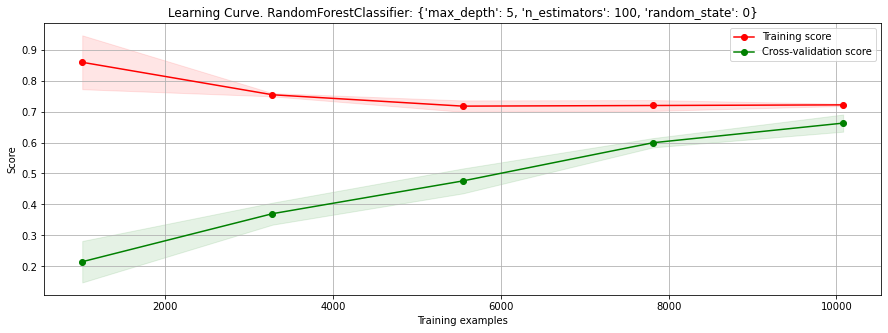

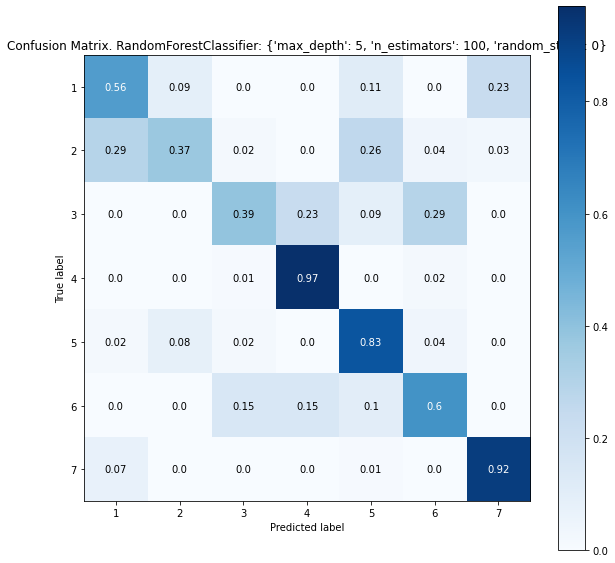

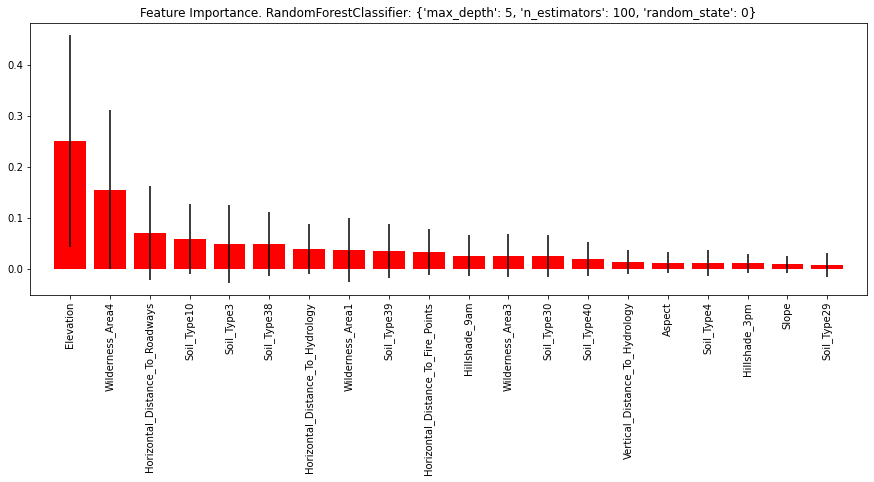

In [42]:
run_cv_model(RandomForestClassifier, {'max_depth': 5, 'n_estimators': 100, 'random_state': 0}, X, y, feats)

Jak widać, wynik się poprawił i już jest ponad 60%. Też `confusion-matrix` wygląda inaczej i raczej lepiej, chociaż w niektórych przypadkach wynik "rozmazał się" po innych klasach.

### Zbadajmy dane

Najpierw przypomnijmy, jak można zrobić histogram, np. dla `Horizontal_Distance_To_Roadway`.

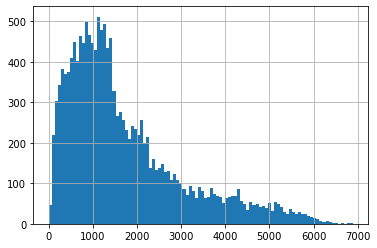

In [43]:
train[ 'Horizontal_Distance_To_Roadways' ].hist(bins=100);

Trochę przyspieszając nasz eksperyment, zobaczmy histogramy dla innych zmiennych numerycznych.

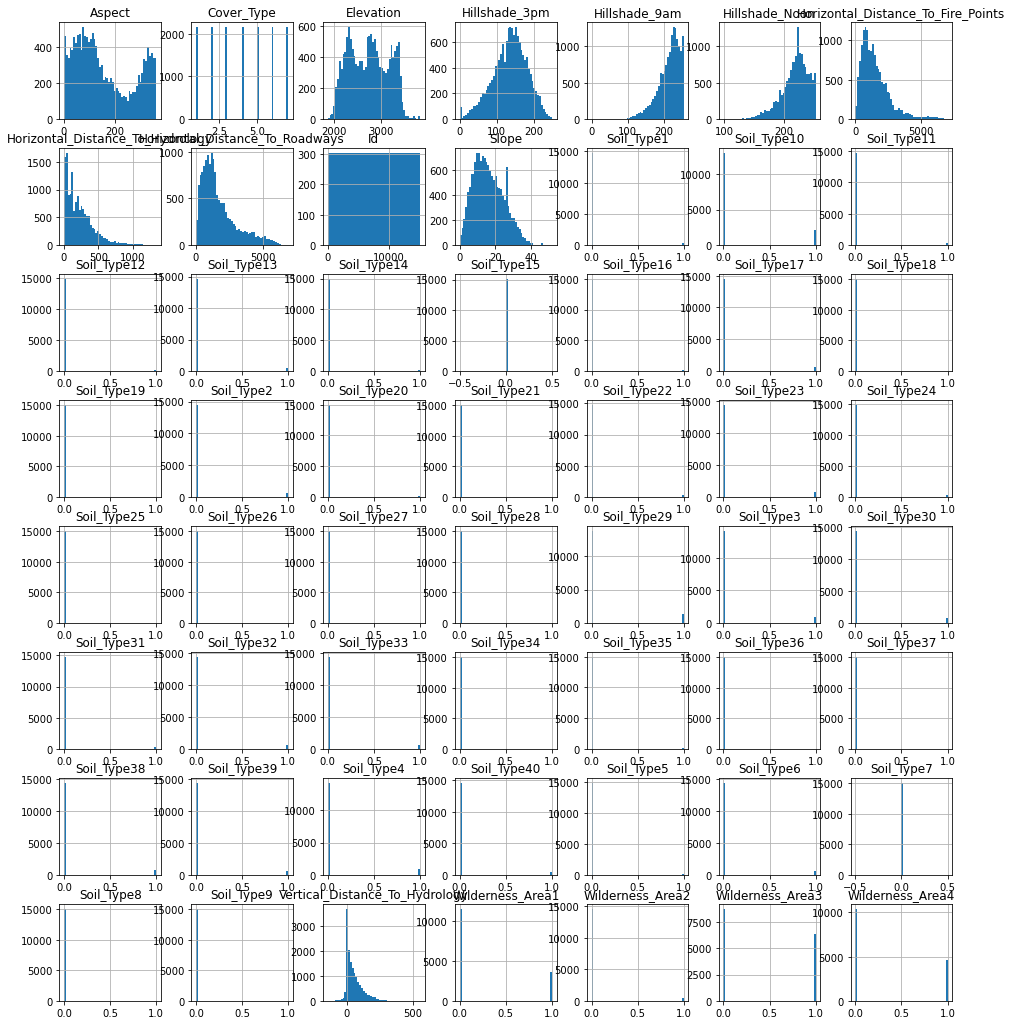

In [49]:
num_feats = train.select_dtypes(np.number).columns
train[num_feats].hist(figsize=(16,18),bins=50);

Trochę za dużo szumu, więc przy okazji widać, że wszystkie kolumny, które mają `Soil` lub `Wilderness` wyglądają dość dziwnie, więc warto je wyeliminować.

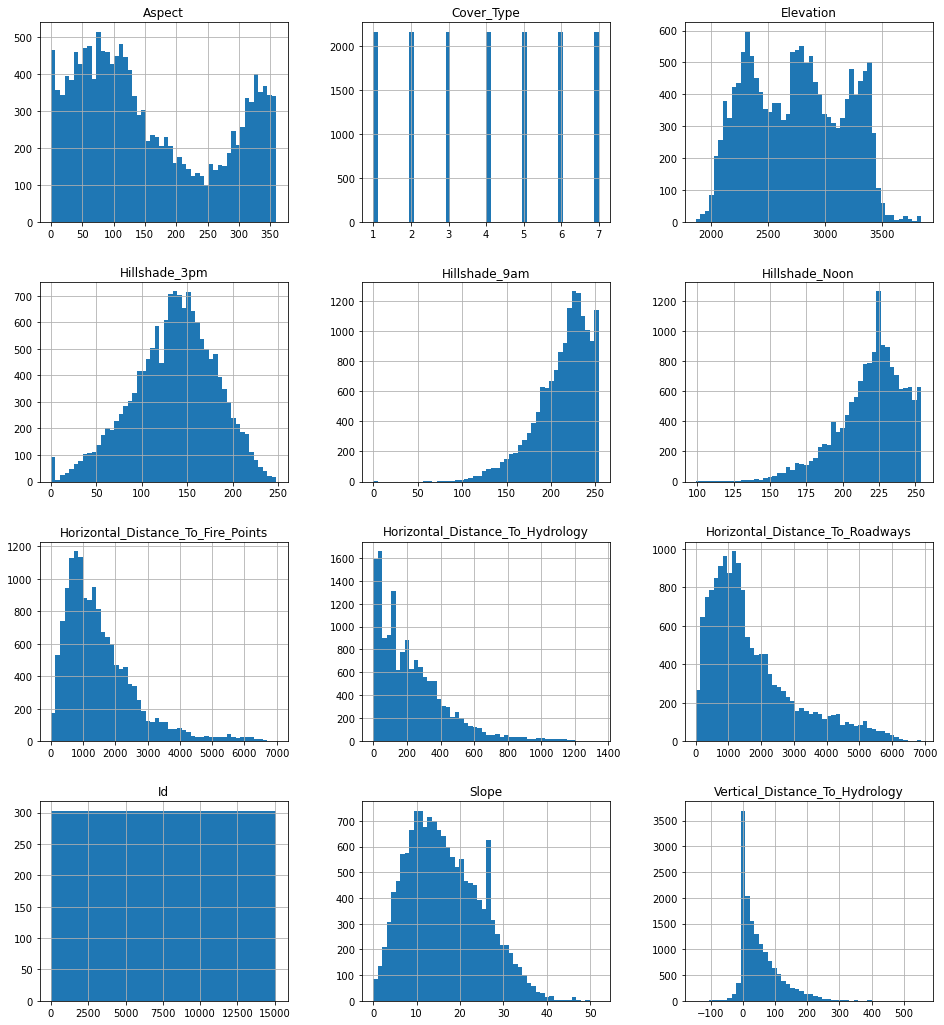

In [50]:
selected_feats = [x for x in num_feats if 'Soil' not in x and 'Wilderness' not in x]

train[selected_feats].hist(figsize=(16,18),bins=50);

## Feature Engineering*

Teraz czas na trochę bardziej zaawansowany feature engineering. W tym przypadku cechy geometryczne (czyli np. odległość) mogą być pomocne. Dlaczego tak? Bo w tym przypadku dane wprost zawierają takie powiązania, czyli mamy jakiś teren, który jest "jakoś" podzielony wg pewnych wzorców. Dlatego w tym przypadku aż prosi się, aby zbadać cechy geometryczne. Możesz też o tym myśleć, jeśli masz problem gdzie są podane współrzędne, to jest szansa, że podobny trick może zadziałać.

Wypiszmy wszystkie cechy, które mają `Distance`.


In [51]:
[x for x in train.columns if 'Distance' in x]

['Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Horizontal_Distance_To_Fire_Points']

Mamy cztery, czyli będzie 6 par:
1. `Horizontal_Distance_To_Hydrology` - `Vertical_Distance_To_Hydrology`
2. `Horizontal_Distance_To_Hydrology` - `Horizontal_Distance_To_Roadways`
3. `Horizontal_Distance_To_Hydrology` - `Horizontal_Distance_To_Fire_Points`
4. `Vertical_Distance_To_Hydrology` - `Horizontal_Distance_To_Roadways`
5. `Vertical_Distance_To_Hydrology` - `Horizontal_Distance_To_Fire_Points`
6. `Horizontal_Distance_To_Roadways` - `Horizontal_Distance_To_Fire_Points`

Mając te pary możemy znaleźć:
- **odległość**, czyli taki wzór $ \sqrt{ x^2 + y^2 } $
i jeszcze trochę dziwnych rzeczy (takie ML'owe podejście),
- **sumę**
- **różnicę**

W wyniku powstanie 6 (par) x 3 (operacji) = 18 cech. 

Zróbmy to!

In [52]:
def distance(x, y):
    return (x.astype('int32')**2 + y.astype('int32')**2) **0.5
    
train['distance_HoHy_VeHy'] = distance(train['Horizontal_Distance_To_Hydrology'], train['Vertical_Distance_To_Hydrology'])
train['distance_HoHy_HoRo'] = distance(train['Horizontal_Distance_To_Hydrology'], train['Horizontal_Distance_To_Roadways'])
train['distance_HoHy_HoFi'] = distance(train['Horizontal_Distance_To_Hydrology'], train['Horizontal_Distance_To_Fire_Points'])
train['distance_VeHy_HoRo'] = distance(train['Vertical_Distance_To_Hydrology'], train['Horizontal_Distance_To_Roadways'])
train['distance_VeHy_HoFi'] = distance(train['Vertical_Distance_To_Hydrology'], train['Horizontal_Distance_To_Fire_Points'])
train['distance_HoRo-HoFI'] = distance(train['Horizontal_Distance_To_Roadways'], train['Horizontal_Distance_To_Fire_Points'])


train['minus_HoHy_VeHy'] = abs(train['Horizontal_Distance_To_Hydrology'] - train['Vertical_Distance_To_Hydrology'])
train['minus_HoHy_HoRo'] = abs(train['Horizontal_Distance_To_Hydrology'] - train['Horizontal_Distance_To_Roadways'])
train['minus_HoHy_HoFi'] = abs(train['Horizontal_Distance_To_Hydrology'] - train['Horizontal_Distance_To_Fire_Points'])
train['minus_VeHy_HoRo'] = abs(train['Vertical_Distance_To_Hydrology'] - train['Horizontal_Distance_To_Roadways'])
train['minus_VeHy_HoFi'] = abs(train['Vertical_Distance_To_Hydrology'] - train['Horizontal_Distance_To_Fire_Points'])
train['minus_HoRo-HoFI'] = abs(train['Horizontal_Distance_To_Roadways'] - train['Horizontal_Distance_To_Fire_Points'])


train['sum_HoHy_VeHy'] = train['Horizontal_Distance_To_Hydrology'] + train['Vertical_Distance_To_Hydrology']
train['sum_HoHy_HoRo'] = train['Horizontal_Distance_To_Hydrology'] + train['Horizontal_Distance_To_Roadways']
train['sum_HoHy_HoFi'] = train['Horizontal_Distance_To_Hydrology'] + train['Horizontal_Distance_To_Fire_Points']
train['sum_VeHy_HoRo'] = train['Vertical_Distance_To_Hydrology'] + train['Horizontal_Distance_To_Roadways']
train['sum_VeHy_HoFi'] = train['Vertical_Distance_To_Hydrology'] + train['Horizontal_Distance_To_Fire_Points']
train['sum_HoRo-HoFI'] = train['Horizontal_Distance_To_Roadways'] + train['Horizontal_Distance_To_Fire_Points']

Wytrenujmy model na nowych danych.

mean=0.62, std=0.03, scores=[0.64563492 0.58214286 0.64583333]


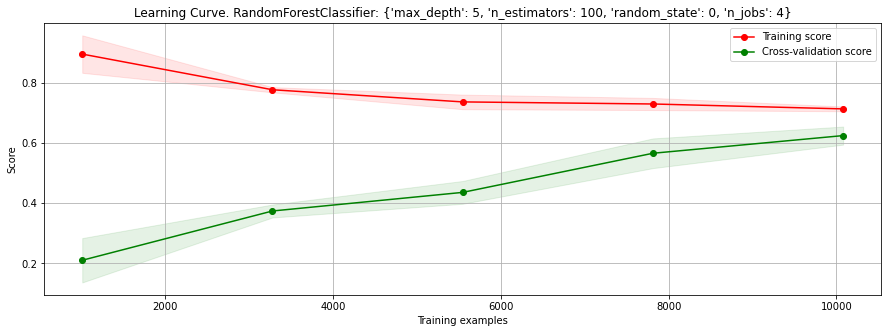

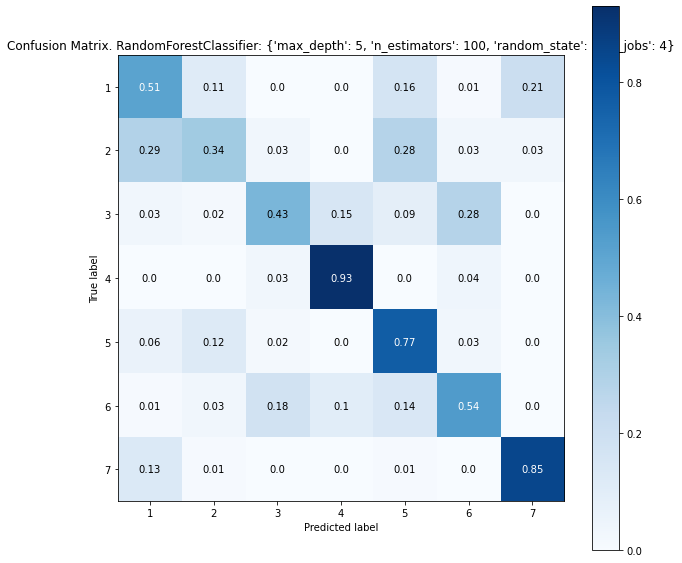

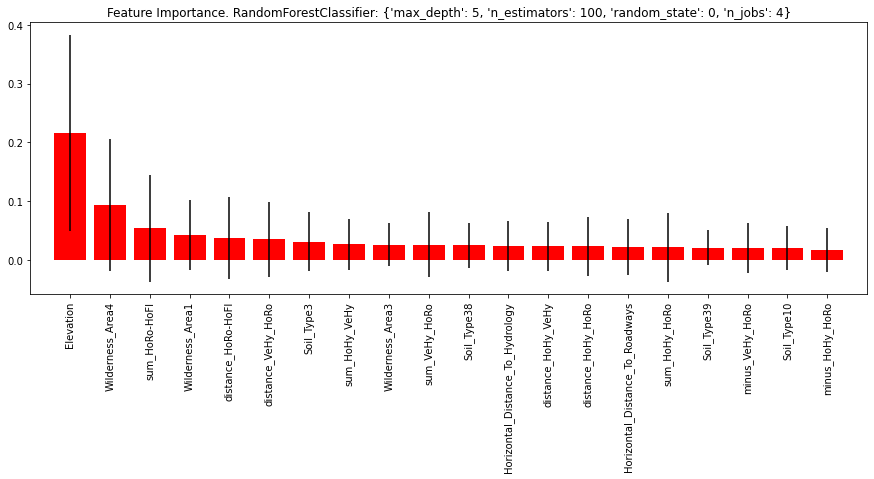

In [53]:
my_feats = get_feats(train)
X, y = get_X_y(train, my_feats)
run_cv_model(RandomForestClassifier, {'max_depth': 5, 'n_estimators': 100, 'random_state': 0, 'n_jobs': 4}, X, y, my_feats)

Wynik znacząco nie poprawił się, chociaż nowe cechy "zostały zauważone". Być może to model tylko nie wyrabia się (podpowiem jeszcze, co z tym zrobić). Teraz skupmy się na tym, aby utworzyć jeszcze nowe cechy.

Na pierwszym miejscu jest `Elevation`, gdzie również można wykonać podobne operacje "odległości". Tutaj logicznie rzecz biorąc `Elevation` powinno pasować tylko do `Vertical_Distance_To_Hydrology` (bo chodzi o pionową odległość w obu przypadkach). Sprawdźmy to i przy okazji zróbmy też dla innych kombinacji.

Zróbmy teraz tylko dla tych par:
- `Elevation` - `Vertical_Distance_To_Hydrology`
- `Elevation` - `Horizontal_Distance_To_Hydrology`
- `Elevation` - `Horizontal_Distance_To_Roadways`
- `Elevation` - `Horizontal_Distance_To_Fire_Points`

Mamy kolejne 12 cech ;).

In [54]:
train['distance_Elev_VeHy'] = distance(train['Elevation'], train['Vertical_Distance_To_Hydrology'])
train['distance_Elev_HoHy'] = distance(train['Elevation'], train['Horizontal_Distance_To_Hydrology'])
train['distance_Elev_HoRo'] = distance(train['Elevation'], train['Horizontal_Distance_To_Roadways'])
train['distance_Elev_HoFi'] = distance(train['Elevation'], train['Horizontal_Distance_To_Fire_Points'])


train['minus_Elev_VeHy'] = abs(train['Elevation'] - train['Vertical_Distance_To_Hydrology'])
train['minus_Elev_HoHy'] = abs(train['Elevation'] - train['Horizontal_Distance_To_Hydrology'])
train['minus_Elev_HoRo'] = abs(train['Elevation'] - train['Horizontal_Distance_To_Roadways'])
train['minus_Elev_HoFi'] = abs(train['Elevation'] - train['Horizontal_Distance_To_Fire_Points'])


train['sum_Elev_VeHy'] = train['Elevation'] + train['Vertical_Distance_To_Hydrology']
train['sum_Elev_HoHy'] = train['Elevation'] + train['Horizontal_Distance_To_Hydrology']
train['sum_Elev_HoRo'] = train['Elevation'] + train['Horizontal_Distance_To_Roadways']
train['sum_Elev_HoFi'] = train['Elevation'] + train['Horizontal_Distance_To_Fire_Points']

Trenujemy model dla nowo utworzonych cech.

mean=0.65, std=0.03, scores=[0.62519841 0.64325397 0.69265873]


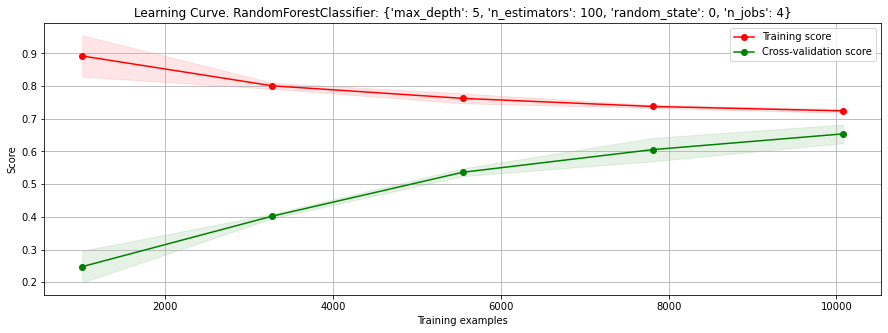

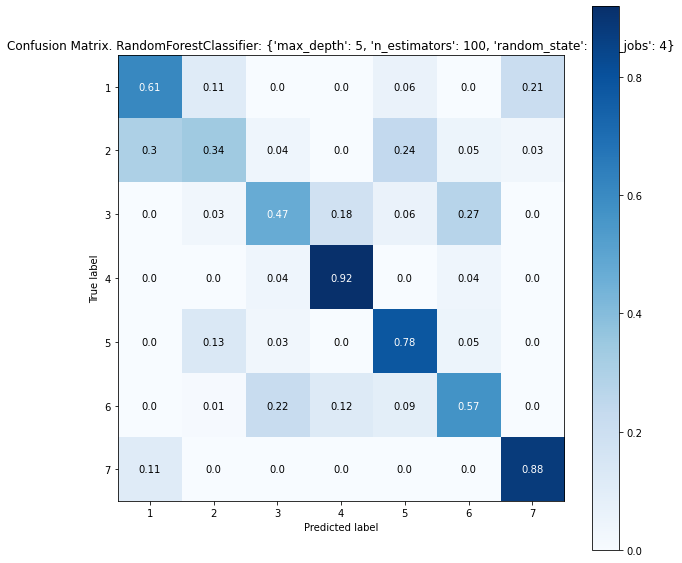

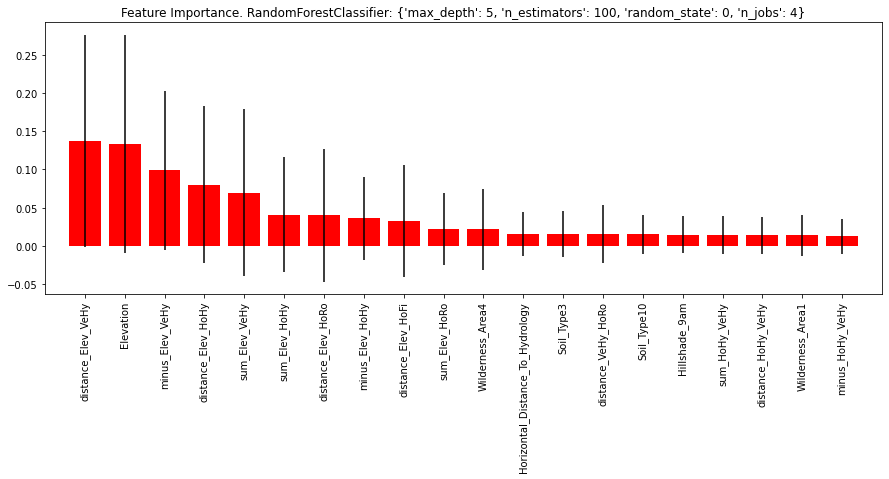

In [55]:
my_feats = get_feats(train)
X, y = get_X_y(train, my_feats)
run_cv_model(RandomForestClassifier, {'max_depth': 5, 'n_estimators': 100, 'random_state': 0, 'n_jobs': 4}, X, y, my_feats)

Wynik delikatnie poprawił się, ale raczej tylko trochę. Natomiast ciekawe jest coś innego, to że ta cecha `minus_Elev_VeHy` stała się numer #1. Zróbmy dla niej wizualizację.

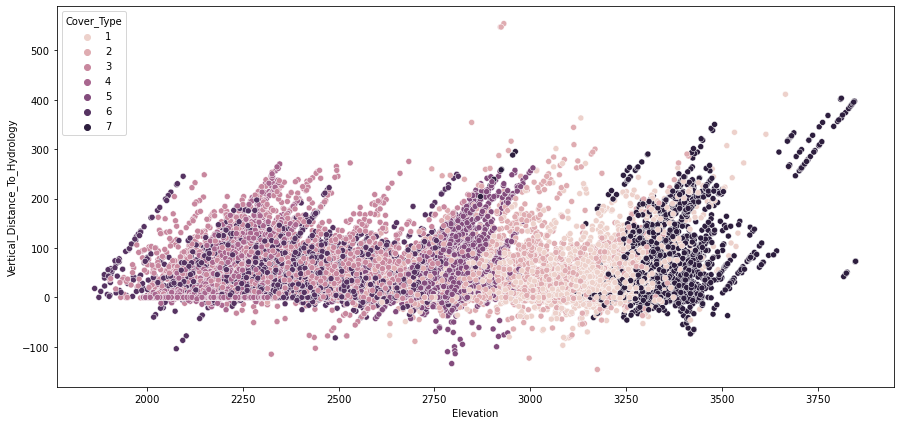

In [56]:
plt.figure(figsize=(15, 7))
sns.scatterplot(x='Elevation', y='Vertical_Distance_To_Hydrology', hue='Cover_Type', data=train);

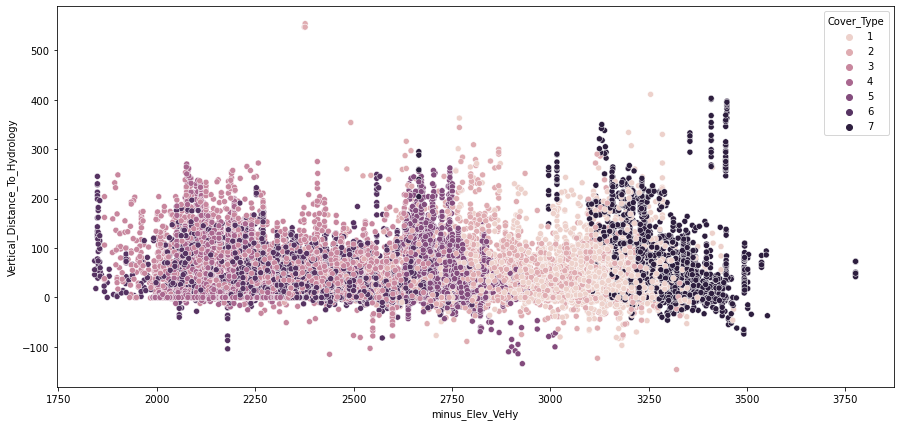

In [57]:
plt.figure(figsize=(15, 7))
sns.scatterplot(x='minus_Elev_VeHy', y='Vertical_Distance_To_Hydrology', hue='Cover_Type', data=train);

Teraz test na Twoją uważność. Zwróciłeś/aś uwagę, że wizualna zależność pomiędzy `Elevation` oraz `Vertical_Distance_To_Hydrology` jest widoczna? Mam nadzieje, że widzisz.

Kąt nachylenia jest dość regularny, prawda? Coś w tym musi być :). W drugim przypadku (po odjęciu) kropki "stoją" w pionie. 

Do tej cechy też można było dojść wizualnie, ale tym razem dotarliśmy do niej z innej strony.


Na koniec bonus i zachęta do kolejnego modułu. W tej sytuacji, w której jesteśmy, cechy, które powstały mogą być fajne, tylko model czyli RandomForest nie może z nich więcej wycisnąć. Trzeba wziąć coś bardziej poważnego, czyli `xgboost`. Na razie tylko uruchomimy ten model jako *black-box* na tych cechach, które udało się znaleźć i zobaczymy, jak sobie poradzi.

In [ ]:
my_feats = get_feats(train)
X, y = get_X_y(train, my_feats)
run_cv_model(xgb.XGBClassifier, {'max_depth': 5, 'n_estimators': 100, 'learning_rate': 0.3, 'col_sample_by_tree': 0.8, 'seed': 0, }, X, y, my_feats)

[17:23:55] WARNING: /workspace/src/learner.cc:480: 
Parameters: { col_sample_by_tree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:24:07] WARNING: /workspace/src/learner.cc:480: 
Parameters: { col_sample_by_tree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:24:20] WARNING: /workspace/src/learner.cc:480: 
Parameters: { col_sample_by_tree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please ope

Gratuluję! Wygląda na to, że udało Ci się dojść do 0.78 i std=0.02 (czyli odchylenie standardowe). Super postęp! Więcej o xgboost będzie w kolejnym module.

## Przydatne linki:


1. [Train/Test Split and Cross Validation in Python](https://bit.ly/3wfzW8x)
2. [How do I evaluate a model?](https://bit.ly/3mdBNpC)
3. [The Ultimate Guide to better Model Performance](https://bit.ly/3mlk4wz)
4. [Model Tuning and the Bias-Variance Tradeoff](https://bit.ly/3dvgprR)
5. [Cross-Validation - paper](https://bit.ly/31Jd7vT)
6. [On Over-fitting in Model Selection and Subsequent Selection Bias in Performance Evaluation - paper](https://bit.ly/3rJBunC)